### Q1

#### Libraries

In [ ]:
import numpy as np
from PIL import Image, ImageOps
from matplotlib import pyplot as plt
import cv2
from tqdm import tqdm

#### Reading Images

In [ ]:
#convert image to an array and convert type from uint8 to int
image1  = np.asarray(ImageOps.grayscale(Image.open('Image1.png'))).astype('int')
image2  = np.asarray(ImageOps.grayscale(Image.open('Image2.png'))).astype('int')

(-0.5, 311.5, 414.5, -0.5)

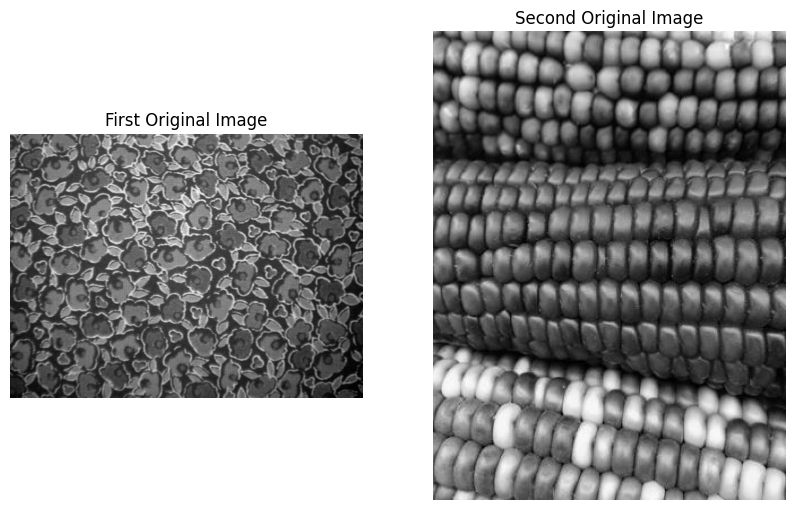

In [ ]:
fig = plt.figure(figsize=(10, 10))
rows = 1
columns = 2
fig.add_subplot(rows, columns, 1)
plt.imshow(image1,cmap = 'gray')
plt.title('First Original Image')
plt.axis('off')
fig.add_subplot(rows, columns, 2)
plt.imshow(image2,cmap = 'gray')
plt.title('Second Original Image')
plt.axis('off')


#### Adding Noies

In [ ]:
def addSaltPepper(img,percent):

      # Get the image dimensions
      rows, cols = img.shape

      # Define the probability of adding noise
      prob = percent/100

      # Create a copy of the original image
      img2 = img.copy()

      # Loop over each pixel and add noise with probability prob
      for i in range(rows):
          for j in range(cols):
              # Generate a random number
              rdn = np.random.random()
              # If the number is smaller than prob/2, set the pixel to 0 (black)
              if rdn < prob/2:
                  img2[i][j] = 0
              # If the number is larger than 1 - prob/2, set the pixel to 255 (white)
              elif rdn > 1 - prob/2:
                  img2[i][j] = 255
      return img2

In [ ]:
def gaussian(img, mean,std):
    rows, cols = img.shape


    # Generate a noise array with the same shape as the image
    noise = np.random.normal(mean, std, (rows, cols))

    # Add the noise to the original image
    img_noise = img + noise
    
    return img_noise


In [ ]:
#Adding salt and pepper noise
image1_salt = addSaltPepper(image1,1)
image2_salt = addSaltPepper(image2,1)
#Adding gaussian noise
image1_gauss = gaussian(image1,0.5,0.1)
image2_gauss = gaussian(image2,0.5,0.1)

(-0.5, 311.5, 414.5, -0.5)

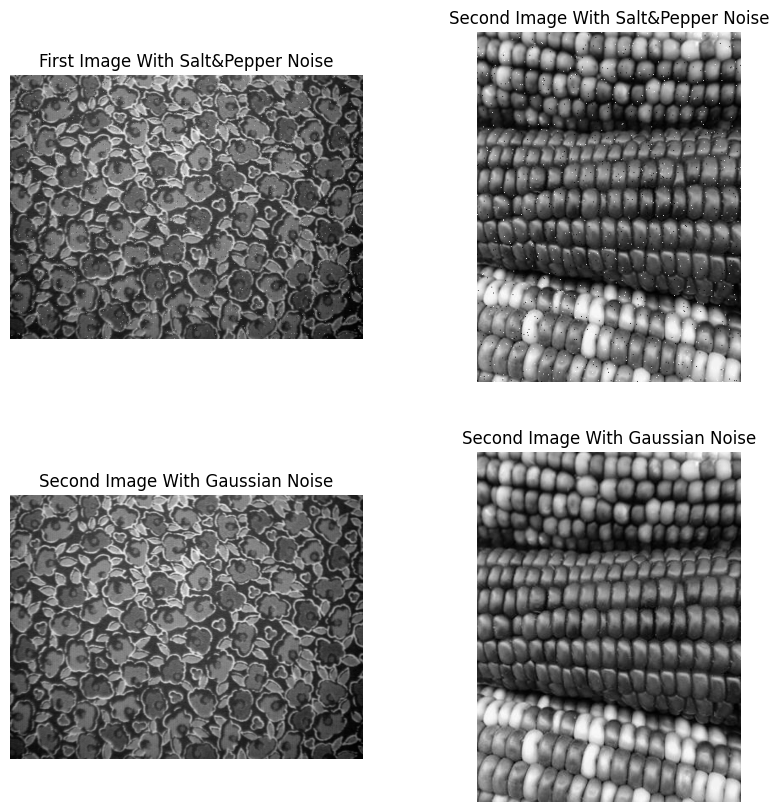

In [ ]:
fig = plt.figure(figsize=(10, 10))
rows = 2
columns = 2
fig.add_subplot(rows, columns, 1)
plt.imshow(image1_salt,cmap = 'gray')
plt.title('First Image With Salt&Pepper Noise')
plt.axis('off')
fig.add_subplot(rows, columns, 2)
plt.imshow(image2_salt,cmap = 'gray')
plt.title('Second Image With Salt&Pepper Noise')
plt.axis('off')
fig.add_subplot(rows, columns, 3)
plt.imshow(image1_gauss,cmap = 'gray')
plt.title('Second Image With Gaussian Noise')
plt.axis('off')
fig.add_subplot(rows, columns, 4)
plt.imshow(image2_gauss,cmap = 'gray')
plt.title('Second Image With Gaussian Noise')
plt.axis('off')



#### Defining Filters

In [ ]:
from scipy.ndimage import convolve

def gaussian_filter(image, kernel_size, sigma):
  # create a 2D Gaussian kernel with the given size and sigma
  k = kernel_size // 2 # half of the kernel size
  x, y = np.mgrid[-k:k+1, -k:k+1] # create a grid of coordinates
  g = np.exp(-(x**2 + y**2) / (2 * sigma**2)) # compute the Gaussian function
  g = g / g.sum() # normalize the kernel to sum to 1
  # convolve the image with the kernel using scipy.ndimage.convolve
  filtered_image = convolve(image, g, mode='reflect')
  return filtered_image

In [ ]:
def scaleImage(max_norm):
  return max(min(255, max_norm), 0)
def NLM(img, sigma=0.5 , Wsim=3,W=3):
    """
    Solve function to perform nlmeans filtering.

    :param img: noisy image
    :param sigma: sigma 
    :param Wsim: size of similarity window
    :param W: size of search window
    """
    padImg = np.pad(img,W//2,mode='reflect')
    # Calculating neighborhood window
    Nw = (sigma**2)*2

    # Getting dimensions of the image
    #h,w = img.shape

    # Initializing the result
    denoised = img - img

    # Finding width of the neighbor window and padded image from the center pixel
    WWidth = W//2
    WsimWidth = Wsim//2

    # Preprocessing the neighbors of each pixel
    neighbors = np.zeros((padImg.shape[0],padImg.shape[1],Wsim,Wsim))

    # Finding the neighbors of each pixel in the original image using the padded image
    for i in range(WWidth,WWidth + img.shape[0]):
        for j in range(WWidth,WWidth + img.shape[1]):   
            neighbors[i,j] = padImg[(i - WsimWidth):(i + WsimWidth + 1) , (j - WsimWidth):(j + WsimWidth + 1)]

    # NL Means algorithm
    for i in range(WWidth, WWidth + img.shape[0]):
        for j in range(WWidth, WWidth + img.shape[1]):
            # similarity array for pixel p
            pixelWindow = neighbors[i,j]

            # search  array for pixel p
            neighborWindow = neighbors[(i - WWidth):(i + WWidth + 1) , (j - WWidth):(j + WWidth + 1)]

            # Calculating Ip using pixelWindow and neighborWindow
            Z1 = 0
            Z2 = 0

            # Calculating distance for pixel p using neighborood pixels q
            for k in range(neighborWindow.shape[0]):
              for z in range(neighborWindow.shape[1]):
                q_window = neighborWindow[k,z]
                exp_value = np.exp(-1*((np.sum((pixelWindow - q_window)**2))/Nw))

                Z1  += (exp_value * (q_window[q_window.shape[0]//2, q_window.shape[1]//2]) )
                Z2 = Z2 + exp_value

            norm = Z1/Z2
            # Cliping the pixel values to stay between 0-255 
            denoised[i - WWidth, j - WWidth] = scaleImage(norm)
            

    return denoised 

#### Calculting PSNR

In [ ]:
def PSNR(original, noisy, peak=255):
  """ 
  param peak: max value of pixel 8-bit image (255)
  """

  # Calculating the Mean Squared Error
  mse = np.mean(np.square(original.astype('float') -  noisy.astype('float')))

  # Calculating the Peak Signal Noise Ratio
  psnr = 10*np.log10(peak**2/mse)

  return psnr

#### Applying On Images With Different Parameter

In [ ]:
def denoising(noisy_image, original_image, parameter, mode):
  PSNR_list = []
  sigma_range = [0.1 , 0.2 , 0.3 , 0.4 , 0.5]
  if(mode == 'NLM'):
      for sigma in tqdm(sigma_range) :
          denoise= NLM(noisy_image.copy(),sigma = sigma ,Wsim =3 ,W = parameter)
          PSNR_list.append(PSNR(original_image,denoise))
  elif(mode == 'gaussian'):
      for sigma in tqdm(sigma_range) :
          denoise= gaussian_filter(noisy_image.copy(),7,sigma)
          PSNR_list.append(PSNR(original_image,denoise))
  return PSNR_list

In [ ]:
PSNR_NLM_3_Image1_salt = denoising(image1_salt, image1, 3, 'NLM')
PSNR_NLM_5_Image1_salt = denoising(image1_salt, image1, 5, 'NLM')
PSNR_NLM_3_Image2_salt = denoising(image2_salt, image2, 3, 'NLM')
PSNR_NLM_5_Image2_salt = denoising(image2_salt, image2, 5, 'NLM')
PSNR_gauss_Image1_salt = denoising(image1_salt, image1, -1, 'gaussian')
PSNR_gauss_Image2_salt = denoising(image2_salt, image2, -1, 'gaussian')

PSNR_NLM_3_Image1_gauss = denoising(image1_gauss, image1, 3, 'NLM')
PSNR_NLM_5_Image1_gauss = denoising(image1_gauss, image1, 5, 'NLM')
PSNR_NLM_3_Image2_gauss = denoising(image2_gauss, image2, 3, 'NLM')
PSNR_NLM_5_Image2_gauss= denoising(image2_gauss, image2, 5, 'NLM')
PSNR_gauss_Image1_gauss = denoising(image1_gauss, image1, -1, 'gaussian')
PSNR_gauss_Image2_gauss = denoising(image2_gauss, image2, -1, 'gaussian')

100%|██████████| 5/5 [00:00<00:00, 242.31it/s]


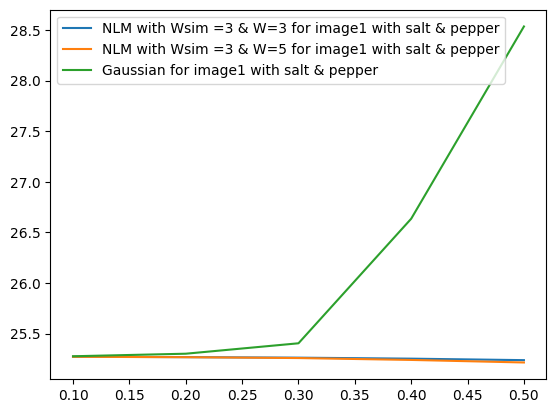

In [ ]:
sigma_range = [0.1 , 0.2 , 0.3 , 0.4 , 0.5]
plt.plot(sigma_range, PSNR_NLM_3_Image1_salt, label ='NLM with Wsim =3 & W=3 for image1 with salt & pepper')
plt.plot(sigma_range, PSNR_NLM_5_Image1_salt, label ='NLM with Wsim =3 & W=5 for image1 with salt & pepper')
plt.plot(sigma_range, PSNR_gauss_Image1_salt, label ='Gaussian for image1 with salt & pepper')
# Function add a legend  
plt.legend()
  
# function to show the plot
plt.show()

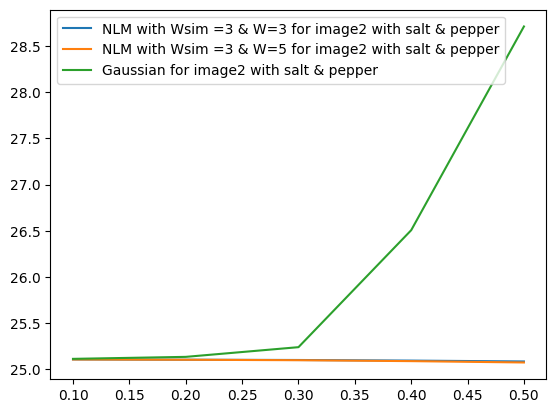

In [ ]:
sigma_range = [0.1 , 0.2 , 0.3 , 0.4 , 0.5]
plt.plot(sigma_range, PSNR_NLM_3_Image2_salt, label ='NLM with Wsim =3 & W=3 for image2 with salt & pepper')
plt.plot(sigma_range, PSNR_NLM_5_Image2_salt, label ='NLM with Wsim =3 & W=5 for image2 with salt & pepper')
plt.plot(sigma_range, PSNR_gauss_Image2_salt, label ='Gaussian for image2 with salt & pepper')
# Function add a legend  
plt.legend()
  
# function to show the plot
plt.show()

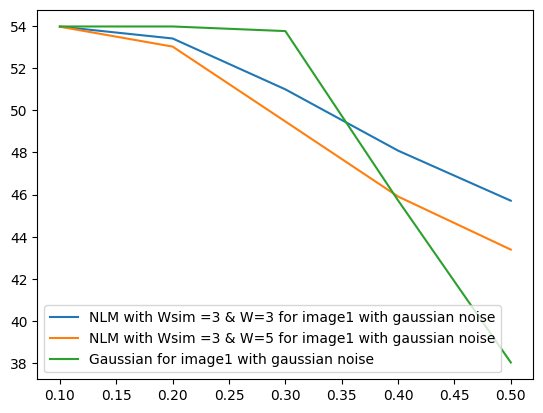

In [ ]:
sigma_range = [0.1 , 0.2 , 0.3 , 0.4 , 0.5]
plt.plot(sigma_range, PSNR_NLM_3_Image1_gauss, label ='NLM with Wsim =3 & W=3 for image1 with gaussian noise')
plt.plot(sigma_range, PSNR_NLM_5_Image1_gauss, label ='NLM with Wsim =3 & W=5 for image1 with gaussian noise')
plt.plot(sigma_range, PSNR_gauss_Image1_gauss, label ='Gaussian for image1 with gaussian noise')
# Function add a legend  
plt.legend()
  
# function to show the plot
plt.show()

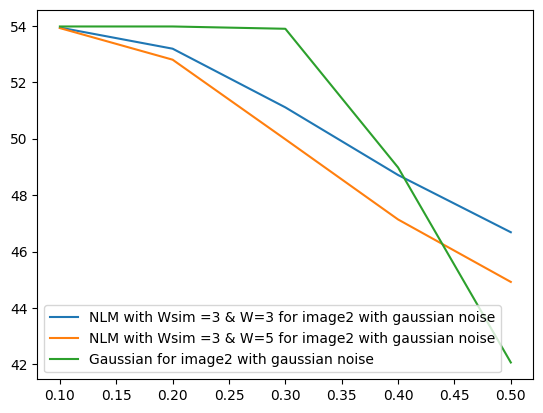

In [ ]:
sigma_range = [0.1 , 0.2 , 0.3 , 0.4 , 0.5]
plt.plot(sigma_range, PSNR_NLM_3_Image2_gauss, label ='NLM with Wsim =3 & W=3 for image2 with gaussian noise')
plt.plot(sigma_range, PSNR_NLM_5_Image2_gauss, label ='NLM with Wsim =3 & W=5 for image2 with gaussian noise')
plt.plot(sigma_range, PSNR_gauss_Image2_gauss, label ='Gaussian for image2 with gaussian noise')
# Function add a legend  
plt.legend()
  
# function to show the plot
plt.show()

(-0.5, 639.5, 479.5, -0.5)

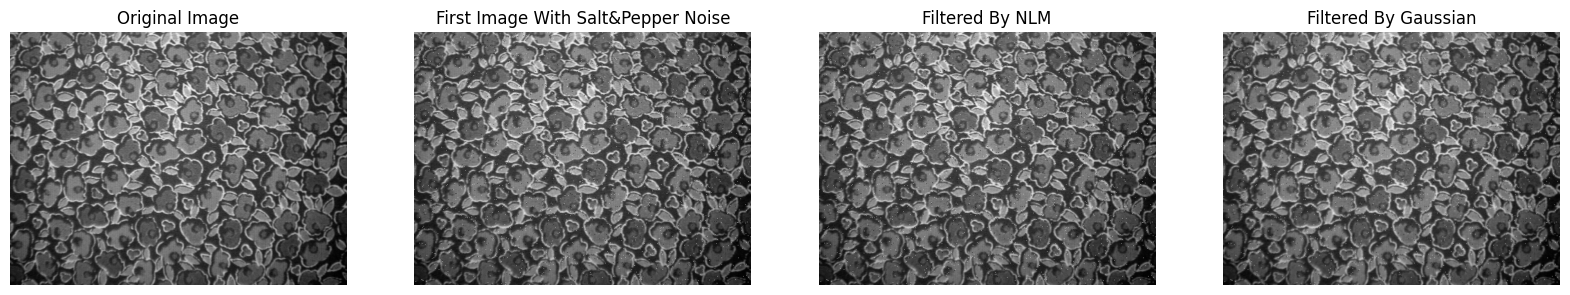

In [ ]:
fig = plt.figure(figsize=(20, 20))
rows = 1
columns = 4
fig.add_subplot(rows, columns, 1)
plt.imshow(image1.astype('uint8'),cmap='gray' )
plt.title('Original Image')
plt.axis('off')
fig.add_subplot(rows, columns, 2)
plt.imshow(image1_salt.astype('uint8'),cmap = 'gray' )
plt.title('First Image With Salt&Pepper Noise')
plt.axis('off')
fig.add_subplot(rows, columns, 3)
plt.imshow(NLM(image1_salt.copy(),sigma = 0.5 ,Wsim =3 ,W = 5).astype('uint8'),cmap='gray' )
plt.title('Filtered By NLM')
plt.axis('off')
fig.add_subplot(rows, columns, 4)
plt.imshow(gaussian_filter(image1_salt.copy(),7,0.5).astype('uint8') ,cmap='gray' )
plt.title('Filtered By Gaussian')
plt.axis('off')


(-0.5, 311.5, 414.5, -0.5)

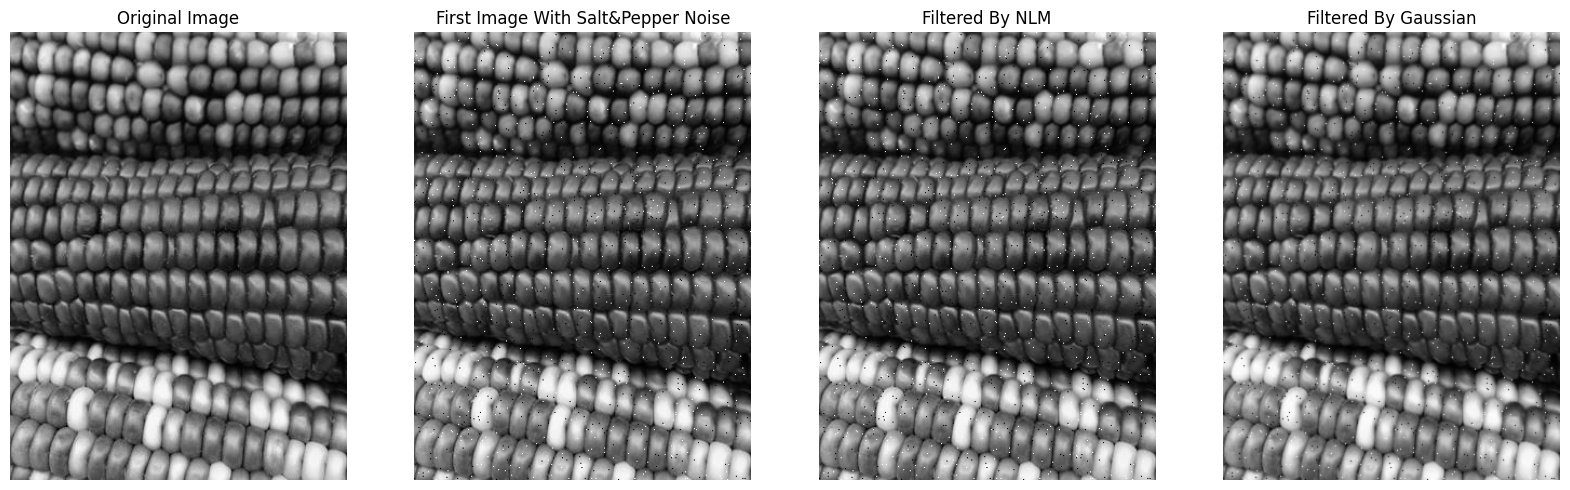

In [ ]:
fig = plt.figure(figsize=(20, 20))
rows = 1
columns = 4
fig.add_subplot(rows, columns, 1)
plt.imshow(image2.astype('uint8'),cmap='gray' )
plt.title('Original Image')
plt.axis('off')
fig.add_subplot(rows, columns, 2)
plt.imshow(image2_salt.astype('uint8'),cmap = 'gray' )
plt.title('First Image With Salt&Pepper Noise')
plt.axis('off')
fig.add_subplot(rows, columns, 3)
plt.imshow(NLM(image2_salt.copy(),sigma = 0.5 ,Wsim =3 ,W = 3).astype('uint8'),cmap='gray' )
plt.title('Filtered By NLM')
plt.axis('off')
fig.add_subplot(rows, columns, 4)
plt.imshow(gaussian_filter(image2_salt.copy(),7,0.5).astype('uint8') ,cmap='gray' )
plt.title('Filtered By Gaussian')
plt.axis('off')


(-0.5, 639.5, 479.5, -0.5)

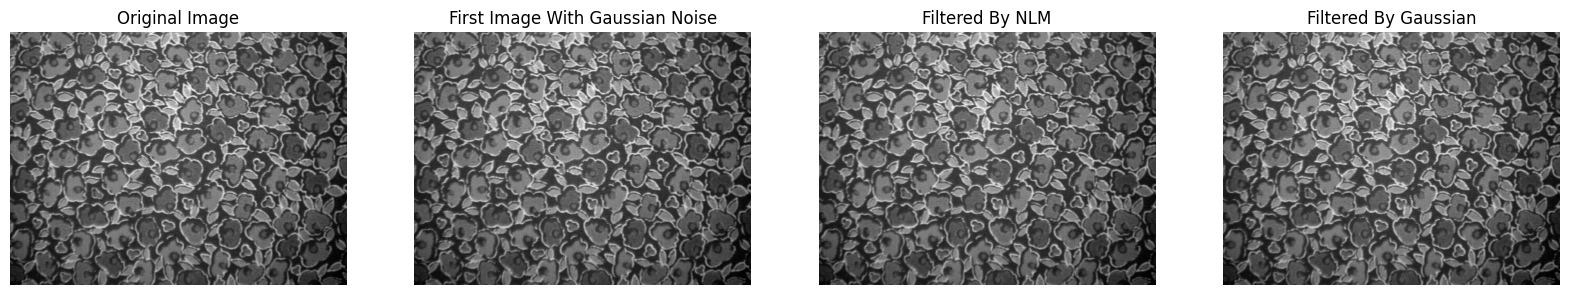

In [ ]:
fig = plt.figure(figsize=(20, 20))
rows = 1
columns = 4
fig.add_subplot(rows, columns, 1)
plt.imshow(image1.astype('uint8'),cmap='gray' )
plt.title('Original Image')
plt.axis('off')
fig.add_subplot(rows, columns, 2)
plt.imshow(image1_gauss.astype('uint8'),cmap = 'gray' )
plt.title('First Image With Gaussian Noise')
plt.axis('off')
fig.add_subplot(rows, columns, 3)
plt.imshow(NLM(image1_gauss.copy(),sigma = 0.1 ,Wsim =3 ,W = 3).astype('uint8'),cmap='gray' )
plt.title('Filtered By NLM')
plt.axis('off')
fig.add_subplot(rows, columns, 4)
plt.imshow(gaussian_filter(image1_gauss.copy(),7,0.1).astype('uint8') ,cmap='gray' )
plt.title('Filtered By Gaussian')
plt.axis('off')


(-0.5, 311.5, 414.5, -0.5)

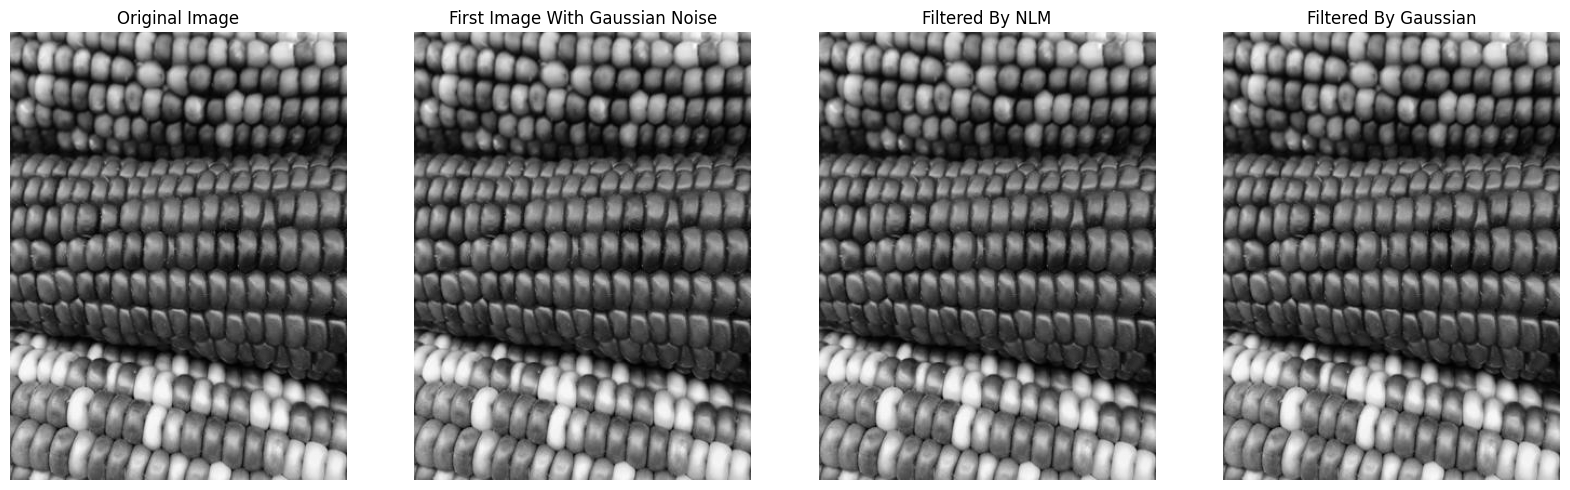

In [ ]:
fig = plt.figure(figsize=(20, 20))
rows = 1
columns = 4
fig.add_subplot(rows, columns, 1)
plt.imshow(image2.astype('uint8'),cmap='gray' )
plt.title('Original Image')
plt.axis('off')
fig.add_subplot(rows, columns, 2)
plt.imshow(image2_gauss.astype('uint8'),cmap = 'gray' )
plt.title('First Image With Gaussian Noise')
plt.axis('off')
fig.add_subplot(rows, columns, 3)
plt.imshow(NLM(image2_gauss.copy(),sigma = 0.1 ,Wsim =3 ,W = 3).astype('uint8'),cmap='gray' )
plt.title('Filtered By NLM')
plt.axis('off')
fig.add_subplot(rows, columns, 4)
plt.imshow(gaussian_filter(image2_gauss.copy(),7,0.1).astype('uint8') ,cmap='gray' )
plt.title('Filtered By Gaussian')
plt.axis('off')


NLM filter is a non-linear filter that uses a weighted average of pixels in a local neighborhood to reduce noise in an image. It works by comparing the similarity between two patches of pixels in an image and then averaging them based on their similarity. NLM filter supports the comparison of regions rather than pixel comparison.

On the other hand, Gaussian filter is a linear filter that uses a Gaussian function to blur an image. It works by convolving an image with a Gaussian kernel to produce a smoothed version of the original image.

In summary, NLM filter is more effective than Gaussian filter in reducing noise in an image because it takes into account the similarity between regions rather than just pixel comparison. However, it is computationally expensive compared to Gaussian filter.


---
In practice it seems that NLM filter is more effective than Gaussian filter in reducing Gaussian noise in an image while blurring less than Gaussian filter. On the other hand, Gaussian filter works better for salt and pepper noise.


### Q2

#### Libraries

In [ ]:
import numpy as np
from PIL import Image, ImageOps
from matplotlib import pyplot as plt
import cv2
from tqdm import tqdm
from scipy.ndimage import convolve

#### Reading Images

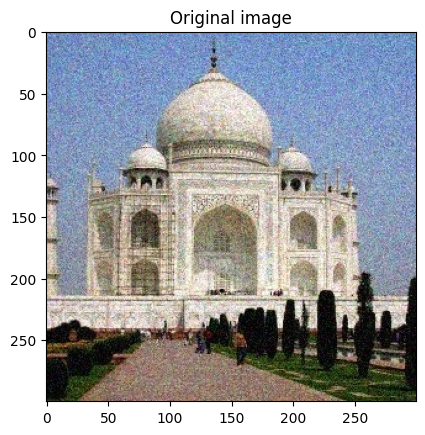

In [ ]:
image  = np.asarray(Image.open('q2.png')).astype('int')
plt.imshow(image)
plt.title('Original image')
plt.show()

#### Normalize pixels

In [ ]:
def scale_array(array, out_range=(0, 255)):
  '''This function normalize an image between range'''
  # Assume array is a numpy array of shape (H, W)
  # Calculate the min and max of the whole array
  min_val = np.min(array)
  max_val = np.max(array)
  # Apply linear transformation
  scaled_array = (array - min_val) / (max_val - min_val) * (out_range[1] - out_range[0]) + out_range[0]
  return scaled_array
def standardImage(img):
  ''' get the absolute values of pixels and then normalize them'''
  img = np.abs(img)
  img = scale_array(img)
  return img

#### Test Spatial Kernel

[[0.11008233 0.11162191 0.11008233]
 [0.11162191 0.11318304 0.11162191]
 [0.11008233 0.11162191 0.11008233]]


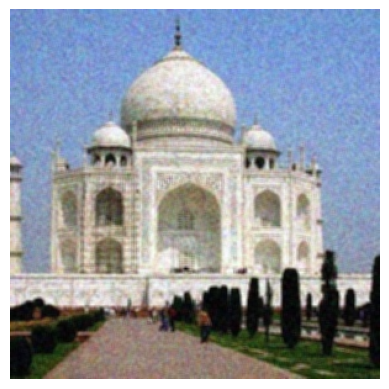

In [ ]:
hx  = 0.02 * max(300, 300)
ksize = 3
image = np.float32(image)
f = np.exp(-np.abs(np.arange(-ksize//2, ksize//2+1)[:,None] - np.arange(-ksize//2, ksize//2+1)[None,:])**2 / (2 * (hx**2)))
f = cv2.getGaussianKernel(ksize,hx)
f = f * f.T
print(f)
image_f = image - image
# apply the spatial filter to the image
for i in range(3):
    image_f[:,:,i] = scale_array(cv2.filter2D(image[:,:,i], -1, f))
plt.imshow(image_f.astype('uint8'))
plt.axis('off')
plt.savefig('q2_filtered_spatial.jpg')
plt.show()

#### Calculting PSNR

In [ ]:
def PSNR(original, noisy, peak=255):
  """ 
  param peak: max value of pixel 8-bit image (255)
  """

  # Calculating the Mean Squared Error
  mse = np.mean(np.square(original.astype('float') -  noisy.astype('float')))

  # Calculating the Peak Signal Noise Ratio
  psnr = 10*np.log10(peak**2/mse)

  return psnr

#### Bilateral Filter

In [ ]:
import numpy as np
import cv2

def bilateral_filter(image, ksize, hx, hg):
    # image: input image
    # ksize: kernel size
    # hx: spatial standard deviation
    # hg: range standard deviation
    # returns: filtered image

    # convert the input image to a float array

    # get image dimensions
    height, width = image.shape[:2]

    # create an empty output image
    output = np.zeros_like(image)

    # create a filter for spatial weights
    #f = np.exp(-np.abs(np.arange(-ksize//2, ksize//2+1)[:,None] - np.arange(-ksize//2, ksize//2+1)[None,:])**2 / (2 * (hx**2)))
    f = cv2.getGaussianKernel(ksize, hx)
    f = f * f.T

    # apply the spatial filter to the image
    image_f = cv2.filter2D(image, -1, f)
    window_kernel = []
    window_image = []

    # iterate over each pixel
    for i in range(height):
        for j in range(width):

            # get the current pixel value
            Ip = image_f[i,j]

            # define the window boundaries
            i_min = max(i - ksize//2, 0)
            i_max = min(i + ksize//2 + 1, height)
            j_min = max(j - ksize//2, 0)
            j_max = min(j + ksize//2 + 1, width)

            # get the window around the current pixel
            I = image_f[i_min:i_max, j_min:j_max]

            # compute the Gaussian filter for range weights
            g = np.exp(-((I - Ip)**2) / (2 * (hg**2)))
            if(i==j and j%10 == 0):
              window_kernel.append(g)
              window_image.append(I)

            #print(g.shape)
            #print(f[i_min-i+ksize//2:i_max-i+ksize//2,j_min-j+ksize//2:j_max-j+ksize//2].shape)
            # compute the bilateral filter response
            Wp = np.sum(f[i_min-i+ksize//2:i_max-i+ksize//2,j_min-j+ksize//2:j_max-j+ksize//2] * g)
            #print((f[i_min-i+ksize//2:i_max-i+ksize//2,j_min-j+ksize//2:j_max-j+ksize//2] * g).shape)
            output[i,j] = np.sum(f[i_min-i+ksize//2:i_max-i+ksize//2,j_min-j+ksize//2:j_max-j+ksize//2] * g * I) / Wp

    return output, window_kernel, window_image

#### Test Bilateral Filter

A bilateral filter is a smoothing filter for images that preserves edges and reduces noise. It has two parameters: hx and hg. hx is the spatial parameter that controls the size of the filter kernel. hg is the range parameter that controls how much the filter is influenced by intensity differences. Choosing hx and hg depends on the image characteristics and the desired effect. Generally, larger values of hx and hg will produce more smoothing, but may also blur edges or create artifacts. Smaller values of hx and hg will preserve more details, but may also retain more noise. A common practice is to use hx = hg = σ, where σ is the standard deviation of the Gaussian distribution used for weighting.

Another way to choose hx and hg for the bilateral filter is to use σd and σr, which are equivalent to hx and hg respectively. σd is the spatial standard deviation and σr is the range standard deviation. As σr increases, the bilateral filter becomes closer to Gaussian blur because the range Gaussian is flatter. As σd increases, the bilateral filter smooths larger features. A good choice of σd and σr depends on the image resolution and noise level. A possible method is to use σd = 2% of the image diagonal and σr = 5% of the intensity range

In [ ]:
height, width = image.shape[:2]
# sigma_s is proportional to the image size
hx  = 0.02 * max(height, width)

# sigma_r is proportional to the image intensity range
hg = 0.05 * (np.max(image) - np.min(image))

In [ ]:
output = image - image
window_kernel= []
window_image = []
for i in range(3):
    output[:,:,i],k,w=  bilateral_filter(image[:,:,i], 3, hx, 100)
    window_kernel.append(k)
    window_image.append(w)


In [ ]:
# A function for show an image with its kernel
def showImageKernel(i,window_image,window_kernel):
    img = np.zeros((3,3,3))
    img[:,:,0] = window_image[0][i]
    img[:,:,1] = window_image[1][i]
    img[:,:,2] = window_image[2][i]
    kernel = np.zeros((3,3,3))
    kernel[:,:,0] = window_kernel[0][i]
    kernel[:,:,1] = window_kernel[1][i]
    kernel[:,:,2] = window_kernel[2][i]
    print("Its Kernel: \n",kernel.view())
    plt.imshow(img.astype('uint8'))
    plt.axis('off')
    plt.title('Image')


Its Kernel: 
 [[[0.99306583 0.99521554 0.99049997]
  [0.9994362  0.99837881 0.99810928]
  [0.99901158 0.99420094 0.99642688]]

 [[0.99597836 0.99945664 0.99663669]
  [1.         1.         1.        ]
  [0.99989307 0.99769258 0.99960715]]

 [[0.99854296 0.99934441 0.99990118]
  [0.99996006 0.99977803 0.99951941]
  [0.99997085 0.99915981 0.99991012]]]


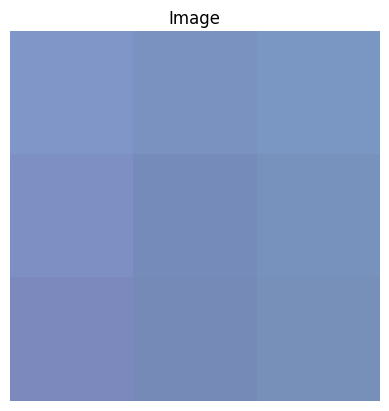

In [ ]:
showImageKernel(5,window_image,window_kernel)

Its Kernel: 
 [[[0.93708748 0.95900714 0.95742297]
  [0.99716687 0.99892133 0.99864835]
  [0.99998218 0.99918455 0.99997449]]

 [[0.97254544 0.98287225 0.98245072]
  [1.         1.         1.        ]
  [0.99746412 0.99999386 0.99915028]]

 [[0.99786699 0.99945182 0.99986345]
  [0.99355048 0.99486274 0.99330461]
  [0.9793399  0.99146193 0.984164  ]]]


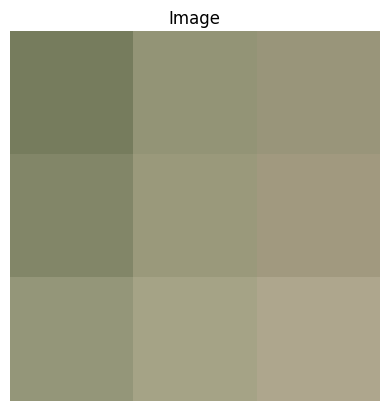

In [ ]:
showImageKernel(10,window_image,window_kernel)

Its Kernel: 
 [[[0.99255145 0.99308729 0.99055034]
  [0.99266934 0.99521679 0.99293941]
  [0.99650002 0.99797273 0.99592316]]

 [[0.99908072 0.9980911  0.99822903]
  [1.         1.         1.        ]
  [0.99970758 0.9997344  0.99986577]]

 [[0.99979353 0.99775887 0.99884361]
  [0.99999815 0.99960661 0.99994707]
  [0.99883837 0.99983388 0.99957049]]]


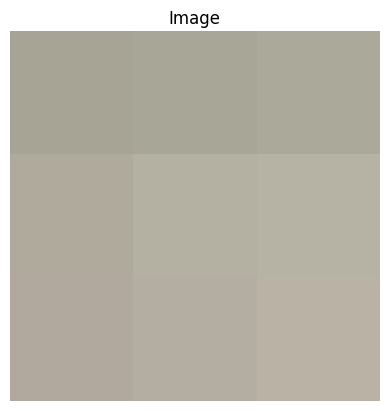

In [ ]:
showImageKernel(20,window_image,window_kernel)

In bilateral filtering, a window of pixels is selected around each pixel in the image, and a kernel function is applied to each pixel in that window. The kernel function is used to calculate the weighted average of the pixel values in the window, where the weights are determined by the distance between each pixel and the center pixel of the window, as well as by the difference between their intensity values. The size of the window and the kernel function used can be adjusted to control the amount of smoothing applied to the image.

Text(0.5, 1.0, 'Bilateral Filter')

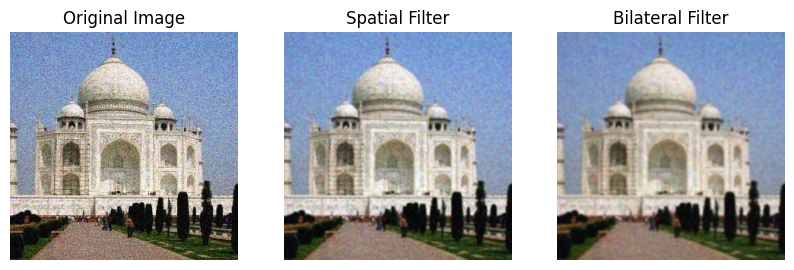

In [ ]:
fig = plt.figure(figsize=(10, 10))
rows = 1
columns = 3
fig.add_subplot(rows, columns, 1)
plt.imshow(image.astype('uint8'))
plt.axis('off')
plt.title('Original Image')
fig.add_subplot(rows, columns, 2)
plt.imshow(image_f.astype('uint8'))
plt.axis('off')
plt.title('Spatial Filter')
fig.add_subplot(rows, columns, 3)
plt.imshow(output.astype('uint8'))
plt.axis('off')
plt.title('Bilateral Filter')

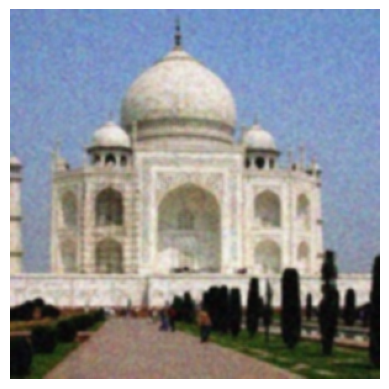

In [ ]:
plt.imshow(output.astype('uint8'))
plt.axis('off')
plt.savefig('res_bilateral.jpg')

### Q3

#### Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.data import shepp_logan_phantom
from skimage.transform import rescale


#### Loading Image

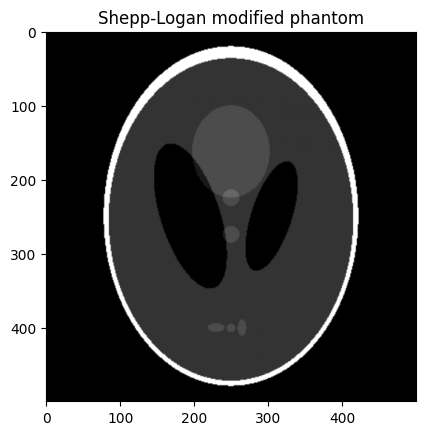

In [43]:
# Generate a 2D phantom image
image = shepp_logan_phantom()

# Rescale the image to 500*500 pixels
image = rescale(image, scale=500/image.shape[0], mode='reflect', channel_axis=None)

# Plot the image
plt.imshow((image*255).astype('uint8'), cmap='gray')
plt.title('Shepp-Logan modified phantom')
plt.show()

#### Adding Gaussian Noise

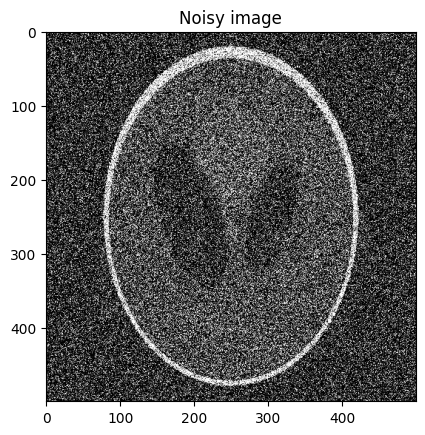

In [44]:
img = image.copy().astype('float32')

# Add gaussian noise
mean = 0
var = 0.3
sigma = var ** 0.5
noise = np.random.normal(mean, sigma, img.shape)
img_noisy = img + noise

# Clip the values to [0, 255]
img_noisy = np.clip(img_noisy, 0, 1)

# Convert back to uint8
#img_noisy = np.uint8(img_noisy)


plt.imshow((img_noisy*255).astype('uint8'), cmap='gray')
plt.title('Noisy image')
plt.show()

#### Filtering By Gaussian Kernel

In [45]:
# Define the Gaussian kernel
def gaussian_kernel(size, sigma):
  # Create a 2D array of zeros
  kernel = np.zeros((size, size))
  # Calculate the center coordinates
  center = size // 2
  # Loop over the kernel elements
  for i in range(size):
    for j in range(size):
      # Calculate the distance from the center
      dist = (i - center) ** 2 + (j - center) ** 2
      # Apply the Gaussian formula
      kernel[i, j] = np.exp(-dist / (2 * sigma ** 2))
  # Normalize the kernel to sum to one
  kernel /= np.sum(kernel)
  return kernel

# Define the local weighted mean filter
def local_weighted_mean_filter(image, kernel):
  # Get the image and kernel dimensions
  height, width = image.shape[:2]
  ksize = kernel.shape[0]
  kcenter = ksize // 2
  # Create an empty array for the output image
  output = np.zeros_like(image)
  # Pad the image with zeros on the borders
  padded = np.pad(image, kcenter, mode='constant')
  # Loop over the image pixels
  for i in range(height):
    for j in range(width):
      # Extract a subimage around the pixel
      subimage = padded[i:i+ksize, j:j+ksize]
      # Multiply the subimage with the kernel element-wise
      weighted = subimage * kernel
      # Sum up the weighted values and assign to the output pixel
      output[i, j] = np.sum(weighted)
  return output

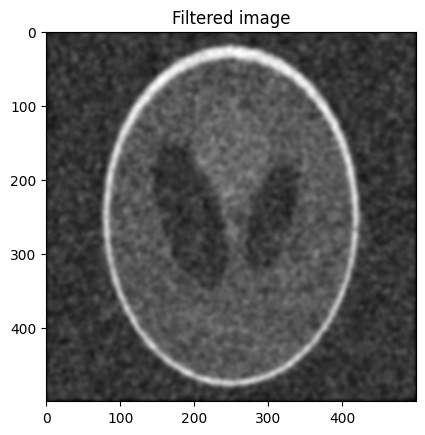

In [52]:
kernel = gaussian_kernel(21, 3)
filtered = local_weighted_mean_filter(img_noisy.astype('float32'), kernel)
plt.imshow((filtered*255).astype('uint8') , cmap='gray')
plt.title('Filtered image')
plt.show()

The main problem is filtering with a Gaussian kernel and local weighted mean may blur the image and reduce its sharpness and contrast

#### Filtering By BM3D

In [48]:
!pip install bm3d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.4 MB/s eta 0:00:00


the BM3D algorithm works as follows:

*    In the first stage, the noisy image is divided into small blocks ofpixels. For each block, similar blocks are found in a large search window around it. The similarity is measured by the Euclidean distance between the blocks. The similar blocks are stacked together to form a 3D array.
*   The 3D array is then transformed into a sparse representation using a 3D transform such as discrete cosine transform (DCT) or wavelet transform. The sparse representation means that most of the coefficients are close to zero and only a few are significant.
*   The coefficients are then hard-thresholded, meaning that the ones below a certain threshold are set to zero and the ones above are kept unchanged. This reduces the noise while preserving the signal.
The inverse 3D transform is applied to obtain a denoised 3D array. The denoised blocks are then aggregated back to the image domain by averaging them with their overlapping counterparts. This reduces the blocking artifacts and improves the quality of the denoised image.
*   In the second stage, the denoised image from the first stage is used as a reference to find similar blocks again. The same steps as in the first stage are repeated, except that instead of hard-thresholding, a Wiener filter is applied to the coefficients. The Wiener filter is a linear filter that minimizes the mean squared error between the original and denoised signals. It adapts to the local signal and noise statistics and preserves more details than hard-thresholding.
*    The final denoised image is obtained by aggregating the denoised blocks from the second stage.

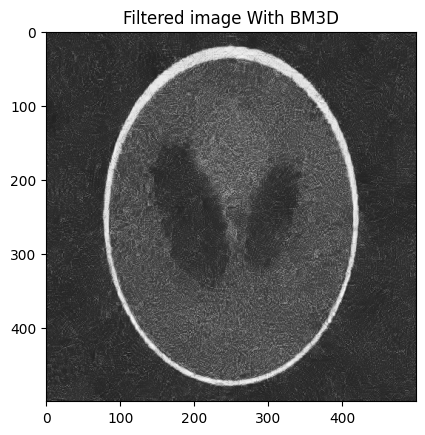

In [57]:
import bm3d

denoised_image = bm3d.bm3d(img_noisy, sigma_psd=60/255, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)
plt.imshow((denoised_image*255).astype('uint8') , cmap='gray')
plt.title('Filtered image With BM3D')
plt.show()

### Q4

#### Libraries

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage.color import rgb2gray
from skimage.io import imread

#### Reading Images and Matching Size

In [ ]:
image_one = imread("res19-near.jpg")
image_two = imread("res20-far.jpg")
# Get the smaller image size
height1, width1,_ = image_one.shape
height2, width2,_ = image_two.shape
min_height = min(height1, height2)
min_width = min(width1, width2)
image_one = cv2.resize(image_one, (min_width, min_height))
image_two = cv2.resize(image_two, (min_width, min_height))


(-0.5, 932.5, 1071.5, -0.5)

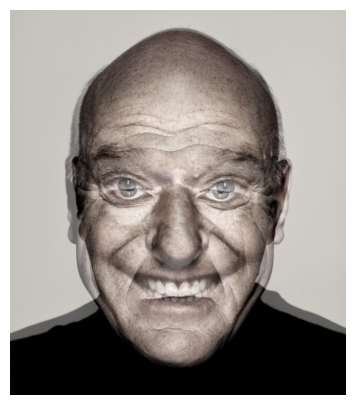

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(image_one)
plt.imshow(image_two, alpha=0.5)
plt.axis('off')

#### Mapping Images

In [ ]:
def align_images(img_one, img_two):
    h1, w1,_ = img_one.shape
    h, w,_ = img_two.shape
    src_points = np.array(
        [[322, 479], [595, 485], [157, 412], [775, 416],  [0, 0], [0, h1 - 1],
         [w1 - 1, 0], [w1 - 1, h1 - 1]], dtype=float)
    dst_points = np.array(
        [[335, 505], [555, 500], [172, 414], [763, 424],  [0, 0], [0, h - 1],
         [w - 1, 0], [w - 1, h - 1]], dtype=float)
    transform, f = cv2.findHomography(src_points, dst_points)
    img_one = cv2.warpPerspective(img_one, transform, (w, h))
    return img_one

In [ ]:
image_one = align_images(image_one, image_two)

(-0.5, 932.5, 1071.5, -0.5)

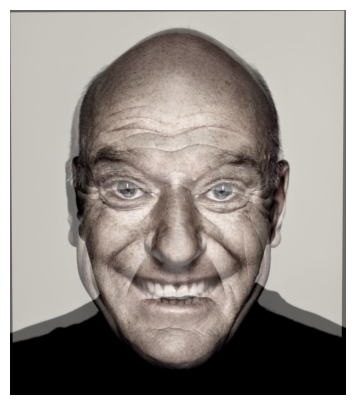

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(image_one)
plt.imshow(image_two, alpha=0.5)
plt.axis('off')

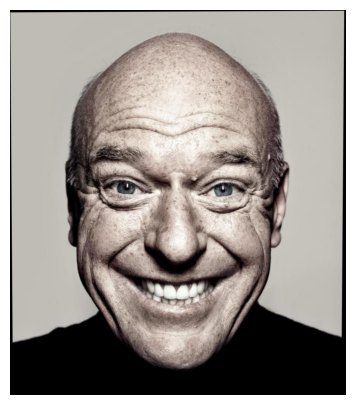

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(image_one)
plt.axis('off')
plt.savefig('wavelet-near-aligned.jpg')

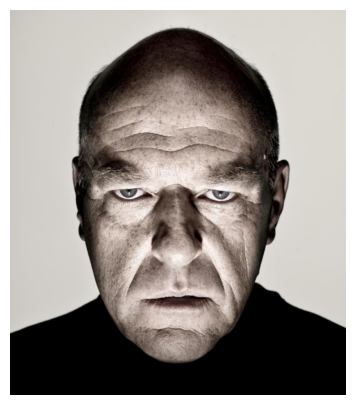

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(image_two)
plt.axis('off')
plt.savefig('wavelet-far-aligned.jpg')

#### Inverse Descrete Wavelet Transform On Each image

In [ ]:
image1  = np.asarray(image_one).astype('int')
image2  = np.asarray(image_two).astype('int')

In [ ]:
# Import the pywt module
import pywt

def getTransformeImage(img, mode = 'db1',filter='low'):
      # Perform 2D discrete wavelet transform (DWT) on the image
      # using Daubechies wavelet 'db1'
      coeffs = pywt.dwt2(img, 'db1')

      # The coeffs variable contains four subbands: 
      # approximation (LL), horizontal (LH), vertical (HL) and diagonal (HH)
      LL, (LH, HL, HH) = coeffs

      # To perform lowpass filtering, we can keep only the approximation subband
      # and set the other subbands to zero
      if(filter == 'low'):
          LH = LH - LH
          HL = HL - HL
          HH = HH - HH

      elif(filter == 'high'):
          LL = LL - LL
          HL = HL - HL
          LH = LH - LH

      # Reconstruct the image from the modified coefficients
      filtered_image = pywt.idwt2((LL, (LH, HL, HH)), 'db1')

      return filtered_image


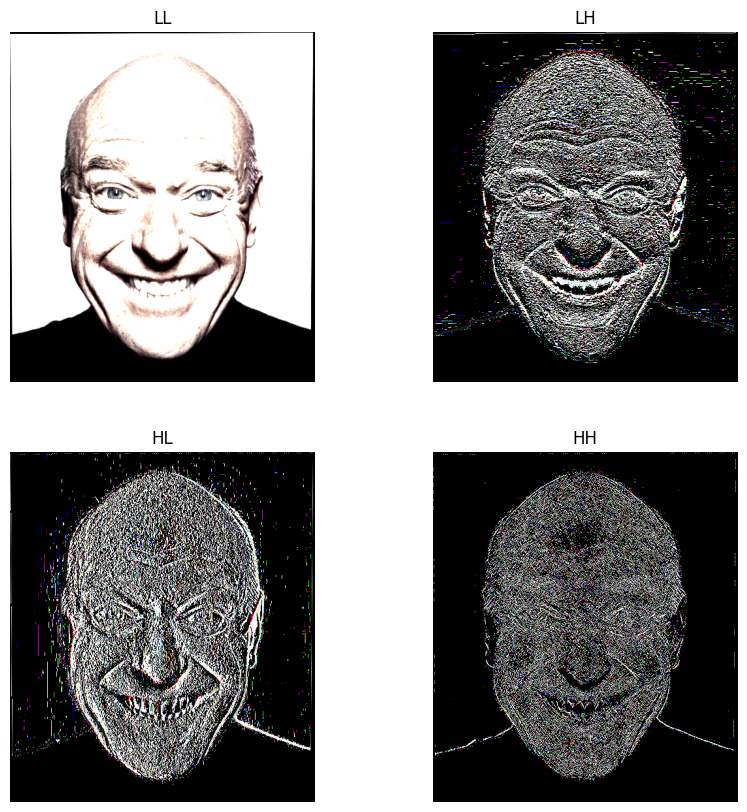

In [ ]:
LL1 = []
LH1 = []
HL1 = []
HH1 = []
for i in range(3):
      coeffs = pywt.dwt2(image1[:,:,i], 'db1')

      # The coeffs variable contains four subbands: 
      # approximation (LL), horizontal (LH), vertical (HL) and diagonal (HH)
      LL, (LH, HL, HH) = coeffs
      LL1.append(LL)
      LH1.append(LH)
      HL1.append(HL)
      HH1.append(HH)
LL1 = np.asarray(LL1).transpose(1, 2, 0)
LH1 = np.asarray(LH1).transpose(1, 2, 0)
HL1 = np.asarray(HL1).transpose(1, 2, 0)
HH1 = np.asarray(HH1).transpose(1, 2, 0)
fig = plt.figure(figsize=(10, 10))
rows = 2
columns = 2
fig.add_subplot(rows, columns, 1)
plt.imshow(LL1.astype('int') )
plt.title('LL')
plt.axis('off')
fig.add_subplot(rows, columns, 2)
plt.imshow(LH1.astype('uint8') )
plt.title('LH')
plt.axis('off')
fig.add_subplot(rows, columns, 3)
plt.imshow(HL1.astype('uint8') )
plt.title('HL')
plt.axis('off')
fig.add_subplot(rows, columns, 4)
plt.imshow(HH1.astype('uint8')  )
plt.title('HH')
plt.axis('off')
plt.savefig('wavelet-near-dwt.jpg')

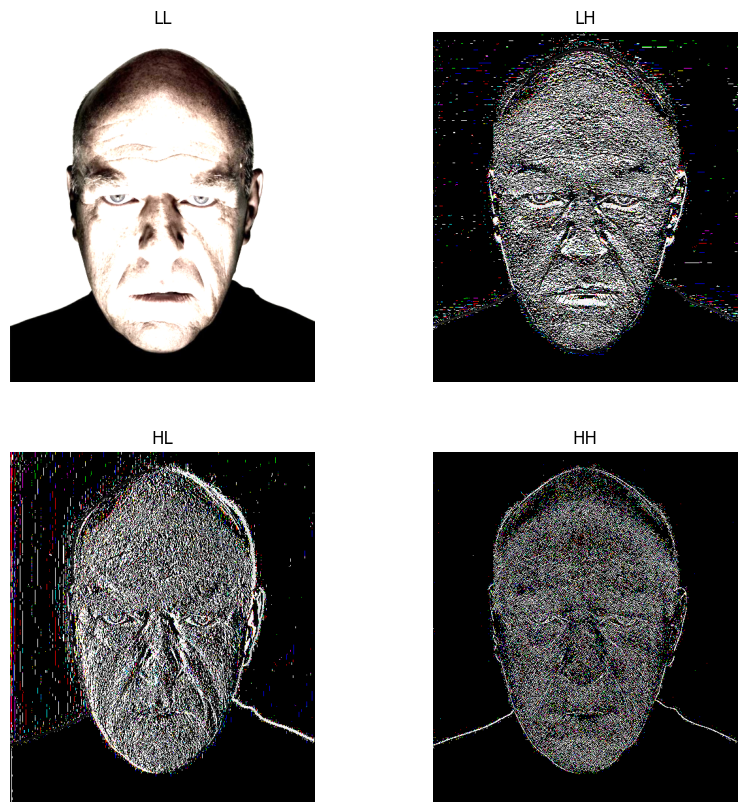

In [ ]:
LL2 = []
LH2 = []
HL2 = []
HH2 = []
for i in range(3):
      coeffs = pywt.dwt2(image2[:,:,i], 'db1')

      # The coeffs variable contains four subbands: 
      # approximation (LL), horizontal (LH), vertical (HL) and diagonal (HH)
      LL, (LH, HL, HH) = coeffs
      LL2.append(LL)
      LH2.append(LH)
      HL2.append(HL)
      HH2.append(HH)
LL2 = np.asarray(LL2).transpose(1, 2, 0)
LH2 = np.asarray(LH2).transpose(1, 2, 0)
HL2 = np.asarray(HL2).transpose(1, 2, 0)
HH2 = np.asarray(HH2).transpose(1, 2, 0)
fig = plt.figure(figsize=(10, 10))
rows = 2
columns = 2
fig.add_subplot(rows, columns, 1)
plt.imshow(LL2.astype('int') )
plt.title('LL')
plt.axis('off')
fig.add_subplot(rows, columns, 2)
plt.imshow(LH2.astype('uint8') )
plt.title('LH')
plt.axis('off')
fig.add_subplot(rows, columns, 3)
plt.imshow(HL2.astype('uint8') )
plt.title('HL')
plt.axis('off')
fig.add_subplot(rows, columns, 4)
plt.imshow(HH2.astype('uint8')  )
plt.title('HH')
plt.axis('off')
plt.savefig('wavelet-far-dwt.jpg')

#### Combine Images

In [ ]:
def combineImages(img1, img2):
      # Perform 2D discrete wavelet transform (DWT) on the image
      # using Daubechies wavelet 'db1'
      coeffs1 = pywt.dwt2(img1, 'db1')
      coeffs2 = pywt.dwt2(img2, 'db1')

      # The coeffs variable contains four subbands: 
      # approximation (LL), horizontal (LH), vertical (HL) and diagonal (HH)
      LL1, (LH1, HL1, HH1) = coeffs1
      LL2, (LH2, HL2, HH2) = coeffs2

      # Reconstruct the image from the modified coefficients
      filtered_image = pywt.idwt2((LL2*0.6+LL1*0.4, ((LH1*0+LH2*0), (HL1*0+HL2*0), HH1*0.8+HH2*0.2)), 'db1')

      return filtered_image

In [ ]:
result = image1 - image1
result[:,:,0] = combineImages(image1[:,:,0],image2[:,:,0])[:,:-1]
result[:,:,1] = combineImages(image1[:,:,1],image2[:,:,1])[:,:-1]
result[:,:,2] = combineImages(image1[:,:,2],image2[:,:,2])[:,:-1]

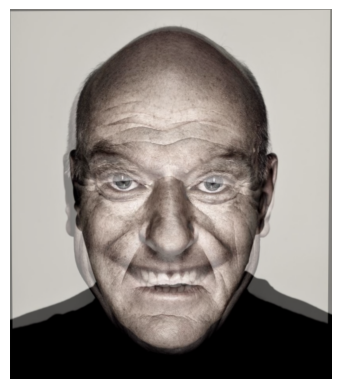

In [ ]:
plt.imshow(result.astype(np.uint8))
plt.axis('off')
plt.savefig('wavelet-hybrid.jpg')
plt.show()

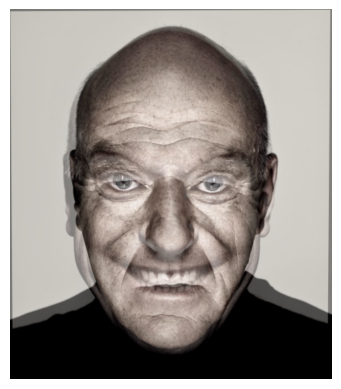

In [ ]:
result_low = result-result
result_low[:,:,0] = getTransformeImage(result[:,:,0])[:,:-1]
result_low[:,:,1] = getTransformeImage(result[:,:,1])[:,:-1]
result_low[:,:,2] = getTransformeImage(result[:,:,2])[:,:-1]
plt.imshow(result_low.astype(np.uint8))
plt.axis('off')
plt.savefig('wavelet-hybrid-near.jpg')
plt.show()

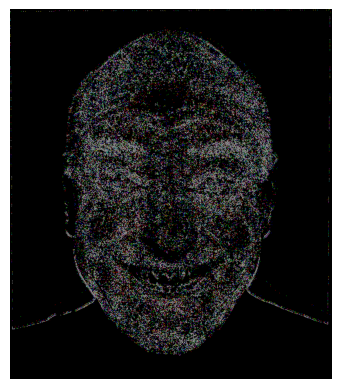

In [ ]:
result_high = result-result
result_high[:,:,0] = getTransformeImage(result[:,:,0],filter='high')[:,:-1]
result_high[:,:,1] = getTransformeImage(result[:,:,1],filter='high')[:,:-1]
result_high[:,:,2] = getTransformeImage(result[:,:,2],filter='high')[:,:-1]
plt.imshow(result_high.astype(np.uint8))
plt.axis('off')
plt.savefig('wavelet-hybrid-far.jpg')
plt.show()

To combine two images using wavelet transform, we first get the wavelet transform coefficients for both images. Then we set the low-high and high-low coefficients to zero for both of them. Since low-low has a lot of information for both images, we collect 40% of the low frequencies of the close image and 60% of the low frequencies of the far image. For high frequencies, we take 30% of the high frequencies of the far image and 70% of the high frequencies of the near image. We do not completely remove either low or high frequency from either image because doing so would make one image invisible.